In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

## Load data


In [2]:
df_train = pd.read_csv("train.csv")

In [3]:
df_train.shape

(3000888, 6)

In [4]:
df_test = pd.read_csv("test.csv")

In [5]:
df_test.shape

(28512, 5)

In [6]:
df_oil = pd.read_csv("oil.csv")
df_stores = pd.read_csv("stores.csv")
df_transactions = pd.read_csv("transactions.csv")
df_holidays = pd.read_csv("holidays_events.csv")

## Pre-processing


In [7]:
# Remove transferred holidays.
df_holidays = df_holidays[~df_holidays["transferred"]]

In [8]:
nat_holidays = df_holidays[df_holidays["locale"] == "National"]
reg_holidays = df_holidays[df_holidays["locale"] == "Regional"].rename(
    columns={"locale_name": "state"}
)
loc_holidays = df_holidays[df_holidays["locale"] == "Local"].rename(
    columns={"locale_name": "city"}
)

### Only 1 local holiday in the test set


In [9]:
df_holidays[
    (pd.to_datetime(df_holidays["date"]) < "2017-08-31")
    & ("2017-08-15" < pd.to_datetime(df_holidays["date"]))
]

,date,type,locale,locale_name,description,transferred
327,2017-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False


In [10]:
def create_features_dataset(df):
    df_out = df.copy()
    # Get the number of days passed since the previous payday (15th and end of month).
    df_out["dist_to_payday"] = pd.to_datetime(df["date"]).dt.day.apply(
        lambda x: x if x < 15 else x - 15
    )
    df_out["weekday"] = pd.to_datetime(df["date"]).dt.dayofweek
    df_out["month"] = pd.to_datetime(df["date"]).dt.month - 1  # 0-indexed
    df_out["oil_price"] = (
        df.set_index("date").join(df_oil.set_index("date"))["dcoilwtico"].values
    )
    stores_cols = df_stores.set_index("store_nbr").columns
    df_out[stores_cols] = (
        df.set_index("store_nbr")
        .join(df_stores.set_index("store_nbr"))[stores_cols]
        .values
    )
    df_out["nat_holiday"] = (
        df_out.set_index("date")
        .join(nat_holidays.drop_duplicates("date").set_index("date"), rsuffix="_holi")[
            "type_holi"
        ]
        .notna()
        .values
    )
    df_out["reg_holiday"] = (
        df_out.set_index(["date", "state"])
        .join(
            reg_holidays.drop_duplicates(["date", "state"]).set_index(
                ["date", "state"]
            ),
            rsuffix="_holi",
        )["type_holi"]
        .notna()
        .values
    )
    df_out["loc_holiday"] = (
        df_out.set_index(["date", "city"])
        .join(
            loc_holidays.drop_duplicates(["date", "city"]).set_index(["date", "city"]),
            rsuffix="_holi",
        )["type_holi"]
        .notna()
        .values
    )
    df_out["is_holiday"] = (
        df_out["nat_holiday"] | df_out["reg_holiday"] | df_out["loc_holiday"]
    )

    return df_out

In [11]:
df_tr = create_features_dataset(df_train)

In [12]:
df_te = create_features_dataset(df_test)

In [13]:
df_merged = pd.concat([df_tr, df_te]).reset_index(drop=True)

In [14]:
df_merged.to_parquet("merged.parquet", index=False)

In [15]:
STORE_TO_I = {s: i for i, s in enumerate(df_tr["store_nbr"].unique())}
I_TO_STORE = {i: s for i, s in enumerate(df_tr["store_nbr"].unique())}
FAM_TO_I = {f: i for i, f in enumerate(df_tr["family"].unique())}
I_TO_FAM = {i: f for i, f in enumerate(df_tr["family"].unique())}
PROMO_TO_I = {True: 1, False: 0}
I_TO_PROMO = {1: True, 0: False}
MONTH_TO_I = {m: i for i, m in enumerate(df_tr["month"].unique())}
I_TO_MONTH = {i: m for i, m in enumerate(df_tr["month"].unique())}
CITY_TO_I = {c: i for i, c in enumerate(df_tr["city"].unique())}
I_TO_CITY = {i: c for i, c in enumerate(df_tr["city"].unique())}
STATE_TO_I = {s: i for i, s in enumerate(df_tr["state"].unique())}
I_TO_STATE = {i: s for i, s in enumerate(df_tr["state"].unique())}
TYPE_TO_I = {t: i for i, t in enumerate(df_tr["type"].unique())}
I_TO_TYPE = {i: t for i, t in enumerate(df_tr["type"].unique())}
CLUSTER_TO_I = {c: i for i, c in enumerate(df_tr["cluster"].unique())}
I_TO_CLUSTER = {i: c for i, c in enumerate(df_tr["cluster"].unique())}

FORECAST_WINDOW = df_te["date"].nunique()

COLS = [
    "store",
    "family",
    "sales",
    "is_promotion",
    "dist_to_payday",
    "dist_to_next_holiday",
    "weekday",
    "month",
    "oil_price",
    "city",
    "state",
    "type",
    "cluster",
]


def build_sequences(
    df: pd.DataFrame,
    grp_cols: list,
    forecast_window: int = 16,
    val_start: str = "2017-07-31",
    test_start: str = "2017-08-16",
):
    seqs = []
    for i, (_, data) in enumerate(df.groupby(grp_cols)):
        print(i, end="\r")
        data["date"] = pd.to_datetime(data["date"])
        data = data.sort_values("date")

        if i == 0:
            splits = np.where(
                data["date"] < val_start,
                "train",
                np.where(
                    (data["date"] >= val_start) & (data["date"] < test_start),
                    "val",
                    "test",
                ),
            )

        data["store"] = data["store_nbr"].map(STORE_TO_I)
        data["family"] = data["family"].map(FAM_TO_I)

        # Remove holidays by replacing with the previous week value.
        data["sales"] = np.where(
            data["is_holiday"], data["sales"].shift(7), data["sales"]
        )
        data["sales"] = data["sales"].fillna(0)
        data["is_promotion"] = (data["onpromotion"] > 0).map(PROMO_TO_I)

        # For each day, reindex the holiday dates to fill forward:
        data["next_holiday_date"] = data.loc[data["is_holiday"], "date"].reindex(
            data.index, method="bfill"
        )

        # Calculate the distance (in days) to the next holiday:
        data["dist_to_next_holiday"] = (
            data["next_holiday_date"] - data["date"]
        ).dt.days
        data["dist_to_next_holiday"] = data["dist_to_next_holiday"].fillna(
            round(data["dist_to_next_holiday"].mean())
        )
        data["month"] = data["month"].map(I_TO_MONTH)

        # Fillna with the previous value.
        data["oil_price"] = data["oil_price"].bfill()
        data["city"] = data["city"].map(CITY_TO_I)
        data["state"] = data["state"].map(STATE_TO_I)
        data["type"] = data["type"].map(TYPE_TO_I)
        data["cluster"] = data["cluster"].map(CLUSTER_TO_I)

        # New column with the sales of the upcomming n days.
        for i in range(1, forecast_window + 1):
            data[f"sales_next_{i}"] = data["sales"].shift(-i)
            data[f"sales_prev_{i}"] = data["sales"].shift(forecast_window - i)

        # Aggregate sales_next cols into a single list column.
        sales_prev = data[
            [f"sales_prev_{i}" for i in range(1, forecast_window + 1)]
        ].values
        sales_next = data[
            [f"sales_next_{i}" for i in range(1, forecast_window + 1)]
        ].values

        # Crop out the last forecast_window days since the sales_next are NaN.
        seq = (
            torch.tensor(data["id"].values),
            torch.tensor(data[COLS].values),
            torch.tensor(sales_prev),
            torch.tensor(sales_next),
        )
        seqs.append(seq)
    return seqs, splits

In [16]:
for i, (_, data) in enumerate(df_merged.groupby(["store_nbr", "family"])):
    break

In [17]:
seqs, splits = build_sequences(
    df_merged,
    ["store_nbr", "family"],
    forecast_window=FORECAST_WINDOW,
    val_start="2017-07-31",
    test_start="2017-08-16",
)

In [18]:
(splits == "val").sum(), (splits == "test").sum()

(np.int64(16), np.int64(16))

In [19]:
import pickle

with open("seqs.pkl", "wb") as f:
    pickle.dump(
        (
            seqs,
            splits,
            FORECAST_WINDOW,
            COLS,
            STORE_TO_I,
            I_TO_STORE,
            FAM_TO_I,
            I_TO_FAM,
            PROMO_TO_I,
            I_TO_PROMO,
            MONTH_TO_I,
            I_TO_MONTH,
            CITY_TO_I,
            I_TO_CITY,
            STATE_TO_I,
            I_TO_STATE,
            TYPE_TO_I,
            I_TO_TYPE,
            CLUSTER_TO_I,
            I_TO_CLUSTER,
        ),
        f,
    )

## Training


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

with open("seqs.pkl", "rb") as f:
    (
        seqs,
        splits,
        FORECAST_WINDOW,
        COLS,
        STORE_TO_I,
        I_TO_STORE,
        FAM_TO_I,
        I_TO_FAM,
        PROMO_TO_I,
        I_TO_PROMO,
        MONTH_TO_I,
        I_TO_MONTH,
        CITY_TO_I,
        I_TO_CITY,
        STATE_TO_I,
        I_TO_STATE,
        TYPE_TO_I,
        I_TO_TYPE,
        CLUSTER_TO_I,
        I_TO_CLUSTER,
    ) = pickle.load(f)

In [2]:
class ForecastModel(nn.Module):
    def __init__(self, n_hidden, n_output, emb_sz=2, num_layers=2, batch_first=True):
        super(ForecastModel, self).__init__()
        self.embed_store = nn.Embedding(len(STORE_TO_I), emb_sz)
        self.embed_family = nn.Embedding(len(FAM_TO_I), emb_sz)
        self.embed_city = nn.Embedding(len(CITY_TO_I), emb_sz)
        self.embed_state = nn.Embedding(len(STATE_TO_I), emb_sz)
        self.embed_type = nn.Embedding(len(TYPE_TO_I), emb_sz)
        self.embed_cluster = nn.Embedding(len(CLUSTER_TO_I), emb_sz)
        self.embed_promo = nn.Embedding(len(PROMO_TO_I), emb_sz)
        self.embed_month = nn.Embedding(len(MONTH_TO_I), emb_sz)
        self.rnn = nn.LSTM(
            8 * emb_sz + 5, n_hidden, num_layers=num_layers, batch_first=batch_first
        )
        self.relu = nn.ReLU()
        self.out = nn.Linear(n_hidden, n_output)

    def get_col(self, x, col):
        if x.ndim == 1:
            return x[COLS.index(col)].long()
        elif x.ndim == 2:
            return x[:, COLS.index(col)].long()
        elif x.ndim == 3:
            return x[:, :, COLS.index(col)].long()

    def get_cols(self, x, cols):
        if x.ndim == 1:
            return x[[COLS.index(c) for c in cols]]
        elif x.ndim == 2:
            return x[:, [COLS.index(c) for c in cols]]
        elif x.ndim == 3:
            return x[:, :, [COLS.index(c) for c in cols]]

    def forward(self, x, h, c):
        store = self.embed_store(self.get_col(x, "store"))
        family = self.embed_family(self.get_col(x, "family"))
        city = self.embed_city(self.get_col(x, "city"))
        state = self.embed_state(self.get_col(x, "state"))
        xtype = self.embed_type(self.get_col(x, "type"))
        cluster = self.embed_cluster(self.get_col(x, "cluster"))
        promo = self.embed_promo(self.get_col(x, "is_promotion"))
        month = self.embed_month(self.get_col(x, "month"))
        x_num = self.get_cols(
            x,
            [
                "sales",
                "dist_to_payday",
                "dist_to_next_holiday",
                "weekday",
                "oil_price",
            ],
        )
        x_w_embs = torch.cat(
            [store, family, city, state, xtype, cluster, promo, month, x_num],
            dim=x.ndim - 1,
        ).float()
        out_h, (h, c) = self.rnn(x_w_embs, (h, c))
        out = self.relu(self.out(self.relu(out_h)))
        return out, h, c


class SimpleForecastModel(nn.Module):
    def __init__(self, n_hidden, n_output, emb_sz=2, num_layers=2):
        super(SimpleForecastModel, self).__init__()
        self.embed_month = nn.Embedding(len(MONTH_TO_I), emb_sz)
        self.rnn = nn.LSTM(emb_sz + 5, n_hidden, num_layers=num_layers)
        self.relu = nn.ReLU()
        self.out = nn.Linear(n_hidden, n_output)

    def get_col(self, x, col):
        if x.ndim == 1:
            return x[COLS.index(col)].long()
        elif x.ndim == 2:
            return x[:, COLS.index(col)].long()
        elif x.ndim == 3:
            return x[:, :, COLS.index(col)].long()

    def forward(self, x, h, c):
        month = self.embed_month(self.get_col(x, "month"))
        x_num = self.get_cols(
            x,
            [
                "sales",
                "dist_to_payday",
                "dist_to_next_holiday",
                "weekday",
                "oil_price",
            ],
        )
        x_w_embs = torch.cat([month, x_num], dim=x.ndim - 1).float()
        out_h, (h, c) = self.rnn(x_w_embs, (h, c))
        out = self.relu(self.out(self.relu(out_h)))
        return out, h, c

### Full forecast window prediction


In [6]:
import random

HIDDEN_SIZE = 100
NUM_LAYERS = 2
EMB_SZ = 2
BATCH_SIZE = 16

model = ForecastModel(
    HIDDEN_SIZE,
    FORECAST_WINDOW * FORECAST_WINDOW,
    emb_sz=EMB_SZ,
    num_layers=NUM_LAYERS,
    batch_first=False,
)
model.float()

optimizer = optim.Adam(model.parameters(), lr=10**-2.2)

In [7]:
def loss_function(y, y_pred_rates, y_prev):
    idx = ~torch.isnan(y_prev).any((1, 2))
    y_pred = (
        y_prev[idx].unsqueeze(2)
        * y_pred_rates[idx].view(
            idx.sum(), y_pred_rates.shape[1], FORECAST_WINDOW, FORECAST_WINDOW
        )
    ).sum(dim=2)
    return (((y_pred + 1).log() - (y[idx] + 1).log()) ** 2).sum()


def eval_model(model: nn.Module, seqs, splits, split="val", idx=0):
    print("Evaluating model...", end="\r")
    model.eval()
    h = torch.zeros(NUM_LAYERS, len(seqs), HIDDEN_SIZE)
    c = torch.zeros(NUM_LAYERS, len(seqs), HIDDEN_SIZE)

    set_sz = (splits == split).sum()
    if split == "val":
        # Get the idx-th iteration of the validation sequence plus all the train sequence.
        eval_idx = (splits == "val") | (splits == "train")

    elif split == "test":
        # Get the idx-th iteration of the test sequence plus all the train and val sequences.
        eval_idx = (splits == "val") | (splits == "train") | (splits == "test")
    x = torch.cat(
        [seq[1].unsqueeze(1)[eval_idx][: -set_sz + idx] for seq in seqs], dim=1
    )
    y_prev = torch.cat(
        [seq[2].unsqueeze(1)[eval_idx][: -set_sz + idx] for seq in seqs], dim=1
    )
    y = torch.cat(
        [seq[3].unsqueeze(1)[eval_idx][: -set_sz + idx] for seq in seqs], dim=1
    )
    ids = torch.cat(
        [seq[0].unsqueeze(0)[:, -set_sz + idx :] for seq in seqs],
        dim=0,
    )
    with torch.no_grad():
        # Whole sequences go through the model.
        y_pred_rates, _, _ = model(x, h, c)

        # But, we only care for the forecast prediction of the last element of the sequence.
        y_pred_rates = y_pred_rates[-1].unsqueeze(0)
        y_prev = y_prev[-1].unsqueeze(0)
        y = y[-1].unsqueeze(0)

        loss = loss_function(y, y_pred_rates, y_prev)
        loss = torch.sqrt(loss / (x.shape[1] * FORECAST_WINDOW))

        y_preds = (
            y_prev.unsqueeze(2)
            * y_pred_rates.view(
                -1, y_pred_rates.shape[1], FORECAST_WINDOW, FORECAST_WINDOW
            )
        ).sum(dim=2)

    print(f"Eval for split {split} - Loss {loss.item()}", end="\r")

    return loss.item(), y_preds, y, ids

In [11]:
lossi = []
train_lossi = []
val_lossi = []
lrei = []
h = torch.zeros(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE)
c = torch.zeros(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE)

for epoch in range(20):
    random.shuffle(seqs)
    train_split = splits == "train"
    batches = [
        (
            torch.cat(
                [seq[1][train_split].unsqueeze(1) for seq in seqs[i : i + BATCH_SIZE]],
                dim=1,
            ),
            torch.cat(
                [seq[2][train_split].unsqueeze(1) for seq in seqs[i : i + BATCH_SIZE]],
                dim=1,
            ),
            torch.cat(
                [seq[3][train_split].unsqueeze(1) for seq in seqs[i : i + BATCH_SIZE]],
                dim=1,
            ),
        )
        for i in range(0, len(seqs), BATCH_SIZE)
    ]
    lre = torch.linspace(-6, 1.5, len(batches))
    """ for pg in optimizer.param_groups:
        pg["lr"] *= 0.95 """

    model.train()
    epoch_losses = torch.zeros(len(batches))
    for i, (x, y_prev, y) in enumerate(batches):
        for pg in optimizer.param_groups:
            pg["lr"] = 10 ** lre[i]

        if y.sum() == 0 or x.shape[1] != BATCH_SIZE:
            continue
        optimizer.zero_grad()
        y_pred_rates, _, _ = model(x, h, c)
        loss = loss_function(y, y_pred_rates, y_prev)

        # Average the loss and take the square root.
        loss = torch.sqrt(loss / (x.shape[0] * FORECAST_WINDOW * BATCH_SIZE))
        lossi.append(loss.item())
        lrei.append(lre[i])
        if (loss.item() > 1e6) or torch.isnan(loss):
            break
        print(f"Batch {i}/{len(batches)} - Loss {loss.item()}", end="\r")
        loss.backward()
        optimizer.step()
        epoch_losses[i] = loss.item()
    train_loss = epoch_losses.mean().item()
    train_lossi.append(train_loss)
    val_loss, _, _, _ = eval_model(model, seqs, splits, split="val", idx=0)
    val_lossi.append(val_loss)
    print(
        f"Epoch {epoch} - Train Loss {round(train_loss, 5)} - Val Loss {round(val_loss, 5)}"
    )

### Prepare Submission


In [ ]:
PATH = f"model_full_100_2_2_16.pth"
model_full = torch.load(PATH, weights_only=False)
test_loss, y_preds, y, ids = eval_model(model_full, seqs, splits, split="test", idx=0)

In [31]:
pd.DataFrame(
    {"id": ids.view(-1).numpy(), "sales": y_preds.squeeze(0).view(-1).numpy()}
).sort_values("id").to_csv("submission_full_forecast_pred.csv", index=False)

## Sequential forecast prediction


In [24]:
import random

HIDDEN_SIZE = 150
NUM_LAYERS = 3
EMB_SZ = 4
BATCH_SIZE = 16

model = ForecastModel(
    HIDDEN_SIZE,
    FORECAST_WINDOW,
    emb_sz=EMB_SZ,
    num_layers=NUM_LAYERS,
    batch_first=False,
)
model.float()

optimizer = optim.Adam(model.parameters(), lr=10**-2.2)

In [25]:
# Output is the attention weights for the previous 15 days of sales.
def loss_function(y, y_pred_rates, y_prev):
    idx = ~torch.isnan(y_prev).any((1, 2))
    y_pred = (y_prev[idx] * y_pred_rates[idx]).sum(dim=2)
    return (((y_pred + 1).log() - (y[idx] + 1).log()) ** 2).sum()


def eval_model(model: nn.Module, seqs, splits, split="val"):
    print("Evaluating model...", end="\r")
    model.eval()
    h_in = torch.zeros(NUM_LAYERS, len(seqs), HIDDEN_SIZE)
    c_in = torch.zeros(NUM_LAYERS, len(seqs), HIDDEN_SIZE)
    set_sz = (splits == split).sum()
    if split == "val":
        # Get the idx-th iteration of the validation sequence plus all the train sequence.
        eval_idx = (splits == "val") | (splits == "train")

    elif split == "test":
        # Get the idx-th iteration of the test sequence plus all the train and val sequences.
        eval_idx = (splits == "val") | (splits == "train") | (splits == "test")
    x_in = torch.cat(
        [seq[1].unsqueeze(1)[eval_idx][: -set_sz - 1] for seq in seqs], dim=1
    )
    y_prev = torch.cat(
        [seq[2].unsqueeze(1)[eval_idx][-set_sz - 1] for seq in seqs], dim=0
    )
    y = torch.cat([seq[3].unsqueeze(1)[eval_idx][-set_sz - 1] for seq in seqs], dim=0)
    ids = torch.cat(
        [seq[0].unsqueeze(0)[:, -set_sz:] for seq in seqs],
        dim=0,
    )
    y_preds_l = []
    with torch.no_grad():
        for i in range(set_sz):
            if x_in.ndim == 2:
                x_in = x_in.unsqueeze(0)
            y_pred_rates, h_out, c_out = model(x_in, h_in, c_in)
            y_pred_i = (y_prev * y_pred_rates[-1]).sum(dim=1)
            x_in = torch.cat(
                [seq[1].unsqueeze(1)[eval_idx][-set_sz + i] for seq in seqs], dim=0
            )
            x_in[:, COLS.index("sales")] = y_pred_i
            y_prev = torch.cat([y_prev[:, :-1], y_pred_i.unsqueeze(1)], dim=1)
            h_in = h_out
            c_in = c_out
            y_preds_l.append(y_pred_i)

        y_preds = torch.cat([yp.unsqueeze(1) for yp in y_preds_l], dim=1)
        loss = torch.sqrt((((y_preds + 1).log() - (y + 1).log()) ** 2).mean())

    print(f"Eval for split {split} - Loss {loss.item()}", end="\r")

    return loss.item(), y_preds, y, ids

In [27]:
train_lossi = []
val_lossi = []

for epoch in range(30):
    random.shuffle(seqs)
    train_split = splits == "train"
    batches = [
        (
            torch.cat(
                [seq[1][train_split].unsqueeze(1) for seq in seqs[i : i + BATCH_SIZE]],
                dim=1,
            ),
            torch.cat(
                [seq[2][train_split].unsqueeze(1) for seq in seqs[i : i + BATCH_SIZE]],
                dim=1,
            ),
            torch.cat(
                [seq[3][train_split].unsqueeze(1) for seq in seqs[i : i + BATCH_SIZE]],
                dim=1,
            ),
        )
        for i in range(0, len(seqs), BATCH_SIZE)
    ]

    lre = torch.linspace(-6, 2, len(batches))
    if epoch % 2 == 0 and epoch > 0:
        for pg in optimizer.param_groups:
            pg["lr"] *= 0.97
    epoch_losses = torch.zeros(len(batches))
    for i, (x, y_prev, y) in enumerate(batches):
        if y[:, 0].sum() == 0 or x.shape[1] != BATCH_SIZE:
            continue
        h = torch.zeros(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE)
        c = torch.zeros(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE)
        optimizer.zero_grad()
        loss = 0
        y_pred, _, _ = model(x, h, c)
        loss += loss_function(y[:, :, 0], y_pred, y_prev)

        # Average the loss and take the square root.
        loss = torch.sqrt(loss / (x.shape[0] * BATCH_SIZE))
        if (loss.item() > 1e6) or torch.isnan(loss):
            break
        print(f"Batch {i}/{len(batches)} - Loss {loss.item()}", end="\r")
        loss.backward()
        optimizer.step()
        epoch_losses[i] = loss
    train_loss = epoch_losses.mean().item()
    train_lossi.append(train_loss)
    val_loss, _, _, _ = eval_model(model, seqs, splits, split="val")
    val_lossi.append(val_loss)
    print(
        f"Epoch {epoch} - Train Loss {round(train_loss, 5)} - Val Loss {round(val_loss, 5)}"
    )

Epoch 0 - Train Loss 0.43841 - Val Loss 0.53289
Epoch 1 - Train Loss 0.41737 - Val Loss 0.52395


KeyboardInterrupt: 

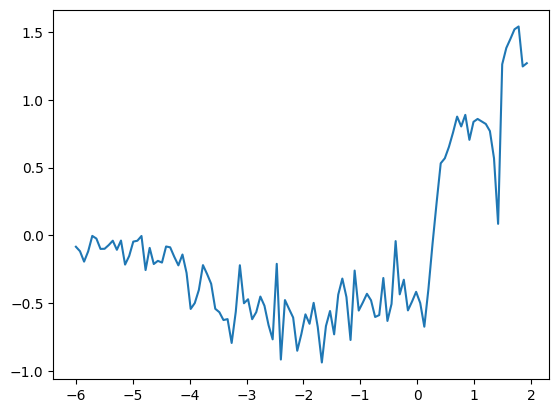

In [23]:
plt.plot(lrei, np.log(lossi))

### Prepare submission


In [4]:
HIDDEN_SIZE = 100
NUM_LAYERS = 2
EMB_SZ = 2
BATCH_SIZE = 16
PATH = f"model_sequential_{HIDDEN_SIZE}_{NUM_LAYERS}_{EMB_SZ}_{BATCH_SIZE}.pth"
model_sequential = torch.load(PATH, weights_only=False)
test_loss, y_preds, y, ids = eval_model(model_sequential, seqs, splits, split="test")

In [6]:
pd.DataFrame(
    {
        "id": ids.view(-1).detach().numpy(),
        "sales": y_preds.squeeze(0).view(-1).detach().numpy(),
    }
).sort_values("id").to_csv("submission_sequential_pred.csv", index=False)

In [14]:
lrei

[tensor([-6.0000, -5.9279, -5.8559, -5.7838, -5.7117, -5.6396, -5.5676, -5.4955,
         -5.4234, -5.3514, -5.2793, -5.2072, -5.1351, -5.0631, -4.9910, -4.9189,
         -4.8468, -4.7748, -4.7027, -4.6306, -4.5586, -4.4865, -4.4144, -4.3423,
         -4.2703, -4.1982, -4.1261, -4.0541, -3.9820, -3.9099, -3.8378, -3.7658,
         -3.6937, -3.6216, -3.5495, -3.4775, -3.4054, -3.3333, -3.2613, -3.1892,
         -3.1171, -3.0450, -2.9730, -2.9009, -2.8288, -2.7568, -2.6847, -2.6126,
         -2.5405, -2.4685, -2.3964, -2.3243, -2.2523, -2.1802, -2.1081, -2.0360,
         -1.9640, -1.8919, -1.8198, -1.7477, -1.6757, -1.6036, -1.5315, -1.4595,
         -1.3874, -1.3153, -1.2432, -1.1712, -1.0991, -1.0270, -0.9550, -0.8829,
         -0.8108, -0.7387, -0.6667, -0.5946, -0.5225, -0.4505, -0.3784, -0.3063,
         -0.2342, -0.1622, -0.0901, -0.0180,  0.0541,  0.1261,  0.1982,  0.2703,
          0.3423,  0.4144,  0.4865,  0.5586,  0.6306,  0.7027,  0.7748,  0.8468,
          0.9189,  0.9910,  

Loss 195.72020448251865


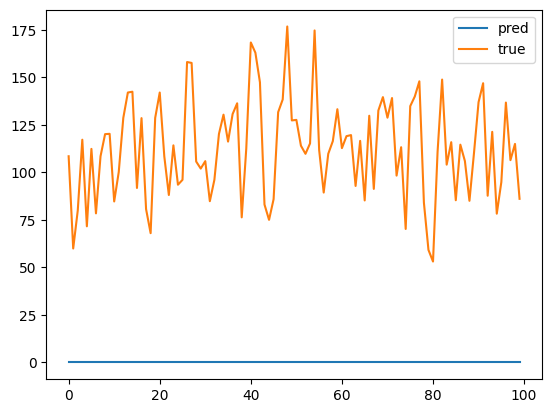

In [367]:
preds_test = []
y_test = []
x, y_prev, y = seqs[10]
h = torch.zeros(NUM_LAYERS, HIDDEN_SIZE)
c = torch.zeros(NUM_LAYERS, HIDDEN_SIZE)
with torch.no_grad():
    y_pred = model(x, h, c)
    loss = loss_function_direct(y[:, 0], y_pred)

    # Average the loss and take the square root.
    loss = torch.sqrt(loss / (x.shape[0]))
    print(f"Loss {loss.item()}")

plt.plot(y_pred[-100:].numpy(), label="pred")
plt.plot(y[:, 0][-100:].numpy(), label="true")
plt.legend()
plt.show()

## Autocorrelation plots


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

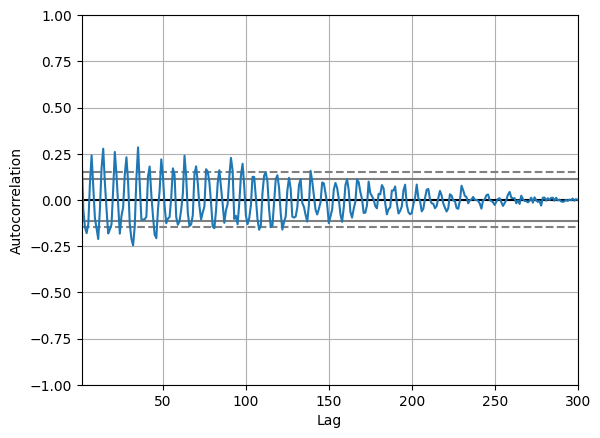

In [45]:
pd.plotting.autocorrelation_plot(
    df_train[(df_train["store_nbr"] == 5) & (df_train["family"] == "AUTOMOTIVE")][
        "sales"
    ][:300]
)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

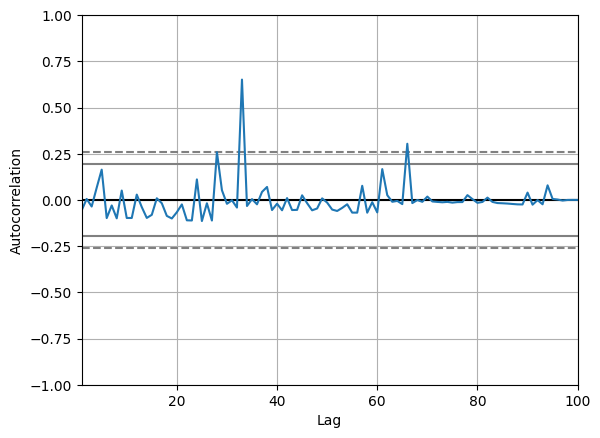

In [28]:
pd.plotting.autocorrelation_plot(
    df_train[df_train["store_nbr"] == 5]["sales"][1000:1100]
)